# Task 3 - Local Binary Patterns

My approach of using Local Binary Patterns stems from my curiosity and previous experience with LBPs. In a [paper](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/iet-bmt.2019.0206) I co-authored (proud haha), we explored the potential of using LBPs to detect face morphs. I wanted to investigate whether the good performance shown here could be transferred from the biometric domain to the medical domain.

LBPs (Local Binary Patterns) are texture descriptors used in computer vision. They encode the local texture patterns in an image by comparing the intensity of a central pixel with its neighboring pixels. LBPs are computationally efficient, robust to illumination changes, and widely used in applications such as facial recognition and texture classification. See example below.

<img src="doc/lbp.png" width="800"/>

In [296]:
import numpy as np
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

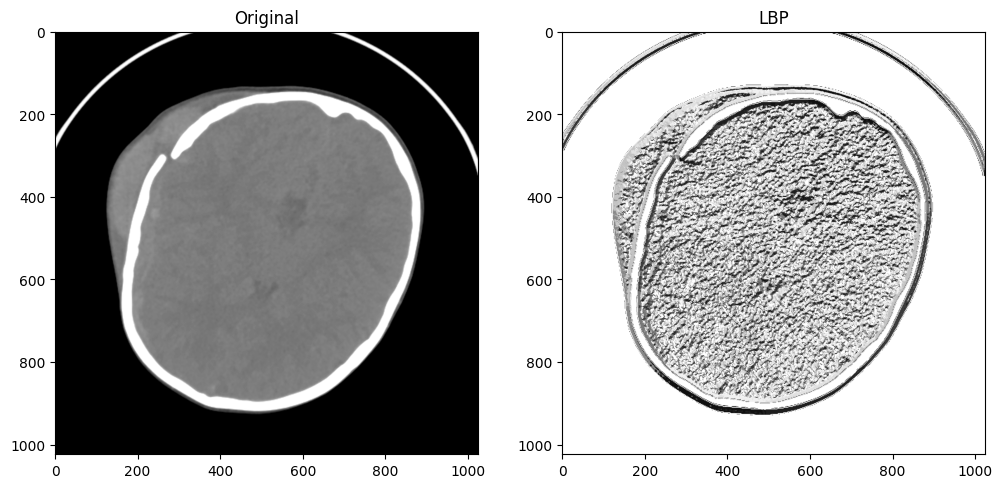

In [297]:
img = Image.open('MedSAM/raw_data/png/train/imgs/051-005.png').convert('L')
img = np.asarray(img, dtype="int32" )

lbp = local_binary_pattern(img, 8, 1)  # 8, 1 (the eight direct neighbors) is the standard LBP, depicted in the image above

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img, cmap="gray")
axs[0].set_title("Original")

axs[1].imshow(lbp, cmap="gray")
axs[1].set_title("LBP")

plt.show()

## Feature Extraction

The CT scan of a patient consists of ~40 slices/images. For each of these images, we extract the LBP code and concatenate these codes into a large feature vector of size 256 * 40 (approximately).

In [298]:
patient_ids = []

for file_name in os.listdir(os.path.join("MedSAM", "raw_data", "all_images_png")):
    patient_ids.append(file_name.split("-")[0])

patient_ids = list(set(patient_ids))

print("Patient IDs: ", patient_ids[:3], "...")

Patient IDs:  ['086', '056', '050'] ...


I wrote a script to convert the nii images to png (see raw_data/nii_to_png_all.ipynb). Here I extract the LBP Features from these png images

In [299]:
for patient_id in tqdm(patient_ids):
    hist_concat = []
    for file_name in os.listdir(os.path.join("MedSAM", "raw_data", "all_images_png")):
        if file_name.split('-')[0] == patient_id:
            img = Image.open(f'MedSAM/raw_data/all_images_png/{file_name}').convert('L')
            img = np.asarray(img, dtype="int32" )

            lbp = local_binary_pattern(img, 8, 1)
            lbp_hist = np.histogram(lbp, bins=range(256))[0]

            hist_concat.append(lbp_hist)

            lbp = Image.fromarray(lbp).convert('L')
            lbp.save(f"MedSAM/raw_data/lbp_images/{file_name.split('.png')[0]}.png")

    hist_concat = np.array(hist_concat).flatten()
    np.save(f"MedSAM/raw_data/lbp_features/{patient_id}", hist_concat)

100%|██████████| 75/75 [03:42<00:00,  2.96s/it]


In [300]:
feature_vector = np.load(f"MedSAM/raw_data/lbp_features/114.npy")
print(feature_vector.shape)

(8160,)


## Combine Demographic and LBP Features

Result of Task 1

In [301]:
demographics = pd.read_csv('demographics_processed.csv')

We combine the demographic and the lbp features. Since the number of slices/images per CT scan varies we can only the use the first 30 slices of every patient because this is the minimal number of slices. Here is room for improvement.

In [302]:
lbp_column_names = [f'lbp_{i}' for i in range(7905)]
final_features = [lbp_column_names + list(demographics.columns)]

for index, row in demographics.iterrows():
    patient_id = int(row["Patient Number"])

    if patient_id in range(59, 66):
        continue

    lbp_features = np.load(os.path.join("MedSAM", "raw_data", "lbp_features", str(patient_id).zfill(3) + ".npy"))
    lbp_features = lbp_features[:7905]

    temp_features = list(lbp_features) + list(row)

    final_features.append(temp_features)

final_features = pd.DataFrame(final_features[1:], columns = final_features[0])

Target:

In [303]:
y = final_features['No Hemorrhage']

In [304]:
final_features = final_features.drop(['No Hemorrhage'], axis=1)

print(final_features.shape)

### Training

I chose Random Forest as the model because it is well-suited for handling a large number of features. With an extensive feature set, Random Forest's ensemble of decision trees can effectively capture complex relationships and patterns in the data. It helps to mitigate overfitting and noise by combining multiple trees' predictions. Additionally, Random Forest provides feature selection and importance measures, which can aid in identifying the most relevant features among the many available.

Since there are a few thousand lbp features, I reduce the dimensionality of the lbp features to 2 using PCA.

In [306]:
# Define the column names and the features to be used
column_names = ["Age", "Fracture", "Male"] + lbp_column_names
used_features = final_features[column_names]

X_train, X_test, y_train, y_test = train_test_split(used_features, y, test_size=0.2)

pca = PCA(n_components=2)
lbp_train_pca_transformed = pca.fit_transform(X_train[lbp_column_names])
lbp_train_pca_transformed = pd.DataFrame(lbp_train_pca_transformed, columns=["lbp_0", "lbp_1"])
lbp_train_pca_transformed.reset_index(drop=True, inplace=True)

X_train = X_train.drop(columns=lbp_column_names)
X_train = pd.concat([X_train.reset_index(drop=True), lbp_train_pca_transformed], axis=1)

lbp_test_pca_transformed = pca.transform(X_test[lbp_column_names])
lbp_test_pca_transformed = pd.DataFrame(lbp_test_pca_transformed, columns=["lbp_0", "lbp_1"])
lbp_test_pca_transformed.reset_index(drop=True, inplace=True)

X_test = X_test.drop(columns=lbp_column_names)
X_test = pd.concat([X_test.reset_index(drop=True), lbp_test_pca_transformed], axis=1)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Plot the feature importances
plt.figure(figsize=(12, 4))
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(40).plot(kind='bar')

accuracy = accuracy_score(y_test, y_pred.round())
print(f"Accuracy: {accuracy}")

Accuracy: 0.6666666666666666


### Comparison

To account for the random nature of data splitting and the variability introduced by the Random Forest algorithm, I perform multiple iterations of training and testing. This approach helps to evaluate the model's performance more robustly and provides a better understanding of its generalization capabilities. By repeating the process with different random splits and Random Forest instances, I can assess the consistency and reliability of the model's results.

In [319]:
number_of_iterations = 1000

In [320]:
only_demographic_results = []
only_demographic_feat_imp = None

for iteration in tqdm(range(number_of_iterations)):
    used_features = pd.concat([final_features[["Age", "Fracture", "Male"]]], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(used_features, y, test_size=0.2)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred.round())
    if only_demographic_feat_imp is None:
        only_demographic_feat_imp = pd.Series(clf.feature_importances_, index=X_train.columns)
    else:
        only_demographic_feat_imp += pd.Series(clf.feature_importances_, index=X_train.columns)
        only_demographic_feat_imp /= 2
    only_demographic_results.append(score)

100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s]


In [321]:
demographics_and_lbp_results = []
demographics_and_lbp_feat_imp = None

for iteration in tqdm(range(number_of_iterations)):
    used_features = final_features[["Age", "Fracture", "Male"] + lbp_column_names]
    X_train, X_test, y_train, y_test = train_test_split(used_features, y, test_size=0.2)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred.round())
    if demographics_and_lbp_feat_imp is None:
        demographics_and_lbp_feat_imp = pd.Series(clf.feature_importances_, index=X_train.columns)
    else:
        demographics_and_lbp_feat_imp += pd.Series(clf.feature_importances_, index=X_train.columns)
        demographics_and_lbp_feat_imp /= 2
    demographics_and_lbp_results.append(score)

100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


In [322]:
demographics_and_pca_lbp_results = []
demographics_and_pca_lbp_feat_imp = None

for iteration in tqdm(range(number_of_iterations)):
    column_names = ["Age", "Fracture", "Male"] + lbp_column_names
    used_features = final_features[column_names]

    X_train, X_test, y_train, y_test = train_test_split(used_features, y, test_size=0.2)

    pca = PCA(n_components=2)

    lbp_train_pca_transformed = pca.fit_transform(X_train[lbp_column_names])
    lbp_train_pca_transformed = pd.DataFrame(lbp_train_pca_transformed, columns=["lbp_0", "lbp_1"])
    lbp_train_pca_transformed.reset_index(drop=True, inplace=True)

    X_train = X_train.drop(columns=lbp_column_names)
    X_train = pd.concat([X_train.reset_index(drop=True), lbp_train_pca_transformed], axis=1)

    lbp_test_pca_transformed = pca.transform(X_test[lbp_column_names])
    lbp_test_pca_transformed = pd.DataFrame(lbp_test_pca_transformed, columns=["lbp_0", "lbp_1"])
    lbp_test_pca_transformed.reset_index(drop=True, inplace=True)

    X_test = X_test.drop(columns=lbp_column_names)
    X_test = pd.concat([X_test.reset_index(drop=True), lbp_test_pca_transformed], axis=1)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    if demographics_and_pca_lbp_feat_imp is None:
        demographics_and_pca_lbp_feat_imp = pd.Series(clf.feature_importances_, index=X_train.columns)
    else:
        demographics_and_pca_lbp_feat_imp += pd.Series(clf.feature_importances_, index=X_train.columns)
        demographics_and_pca_lbp_feat_imp /= 2

    score = accuracy_score(y_test, y_pred.round())
    demographics_and_pca_lbp_results.append(score)

100%|██████████| 1000/1000 [05:52<00:00,  2.83it/s]


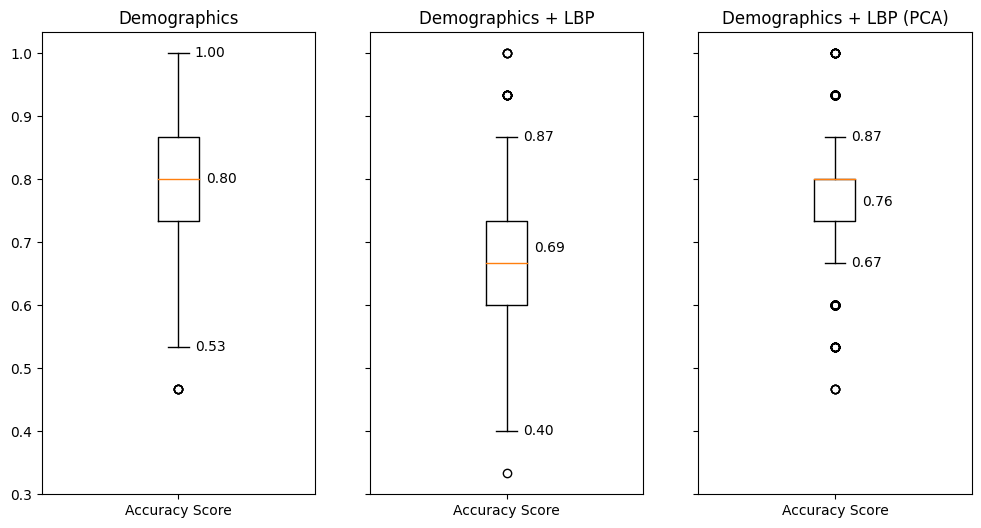

In [323]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

plot_titles = ["Demographics", "Demographics + LBP", "Demographics + LBP (PCA)"]

for i, (data, title) in enumerate(zip([only_demographic_results, demographics_and_lbp_results, demographics_and_pca_lbp_results], plot_titles)):
    data = np.array(data)

    axs[i].set_title(title)

    boxplot = axs[i].boxplot(data)
    whisker_min = boxplot["whiskers"][0].get_ydata()[1]
    whisker_max = boxplot["whiskers"][1].get_ydata()[1]

    mean_score = data.mean()

    axs[i].text(1.06, whisker_min, f"{whisker_min:.2f}", va="center")
    axs[i].text(1.06, whisker_max, f"{whisker_max:.2f}", va="center")
    axs[i].text(1.1, mean_score, f"{mean_score:.2f}", va="center")

    axs[i].set_xticks([1])
    axs[i].set_xticklabels(["Accuracy Score"])

plt.show()

In [329]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_titles = ["Demographics", "Demographics + LBP", "Demographics + LBP (PCA)"]

for i, (data, title) in enumerate(zip([only_demographic_feat_imp, demographics_and_lbp_feat_imp, demographics_and_pca_lbp_feat_imp], plot_titles)):
    axs[i].set_title(title)
    if i == 0:
        axs[i].set_ylabel("Feature Importance")

    data.nlargest(5).plot(kind='bar', ax=axs[i])

plt.show()

### Discussion & Future Work

The box plots reveal interesting insights regarding the different feature combinations. Specifically, when considering demographics-only features, the average accuracy of 0.8 demonstrates the highest performance. On the other hand, the combination of demographics and LBP features yields a lower average accuracy of 0.69, indicating a weaker performance in comparison. However, when applying PCA to the LBP features, the situation changes. The average accuracy of 0.76 becomes comparable to the 0.8 achieved by the demographics-only features. Notably, the interquartile range in this case is considerably smaller, implying a more consistent and reliable performance overall. These findings suggest that while the combination of demographics and LBP features initially underperformed, the incorporation of PCA potentially enhances the performance and brings it closer to that of the demographics-only features.

Regarding the interpretability of the results, it is intriguing to observe that in the third scenario, the first PCA component appears to have the most significant impact on the prediction. However, one inherent challenge of PCA is that the resulting features are not readily explainable on their own. Nevertheless, it could be possible to illustrate to a patient what the LBP transformation does and that its outcome is reflected in the features LBP_0 and LBP_1. In contrast, variables such as Fracture, Age, and Male are intuitively understandable due to their inherent nature and familiarity.

This observation highlights the trade-off between the interpretability of features and their effectiveness in improving prediction accuracy. While demographic variables have straightforward interpretations, the transformation-based features like LBP and PCA may offer superior performance but lack direct human interpretability. It becomes crucial to strike a balance between achieving accurate predictions and maintaining the ability to explain the underlying factors contributing to the model's decisions.

Regarding to my research question, it can be said that the combination of LBPs with demographic information yields promising outcomes, suggesting the potential benefits of incorporating texture-based features alongside demographic features. In future work, additional image transformations could be explored prior to LBP extraction, with a particular focus on cropping. This could reduce the number of irrelevant features (LBP Codes in the outer areas of the images). Furthermore, validating the results obtained thus far with a larger dataset would be valuable. Increasing the dataset size can provide a more comprehensive evaluation of the proposed approach and validate its generalizability.